## Importing Classes & Libraries

In [2]:
import pickle
import pandas as pd
from nltk import sent_tokenize
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer 
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize,sent_tokenize
import nltk 
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import regexp_tokenize
import spacy
import gensim.corpora as corpora
from gensim import corpora, models, similarities, matutils
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import pyLDAvis.sklearn
import warnings
warnings.filterwarnings("ignore")
from __future__ import division
from sklearn.manifold import TSNE
import numpy as np
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
import os
output_notebook()

Loading BokehJS ...

In [3]:
## Defining Functions
nltk.download('stopwords', quiet=True, raise_on_error=True)
stopword_list = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

In [4]:
tokenizer = ToktokTokenizer()

def remove_stopwords(text):
    # convert sentence into token of words
    all_addresses = []
    for addresses in text:    
        tokens = tokenizer.tokenize(addresses)
        tokens = [token.strip() for token in tokens]
        # check in lowercase 
        t = [token for token in tokens if token.lower() not in stopword_list]
        text=' '.join(t)
        all_addresses.append(text)    
    return pd.Series(all_addresses)

In [5]:
def lemma(text,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    # Create list to store all addresses in
    all_addresses = []
    for address in text:
        doc = nlp(address)
        t = " ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        all_addresses.append(t)
    return pd.Series(all_addresses)

In [114]:
# Plotting

def plot_top_words(model, feature_names, n_top_words, title,dim_1,dim_2):
    fig, axes = plt.subplots(dim_1, dim_2, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    fig.tight_layout()
    plt.savefig("{}".format(title))

## Import Data

In [7]:
# Load Pickled Dataframe from Cleaning Notebook into a DataFrame
path = r"C:\Users\Andrew\Documents\Metis\NLP_Inaugural_Addresses\Pickled_Files\cleaned_addresses.pkl"

df = pickle.load(open(path,'rb'))
df.head(100)

,president_number,term,pres_name,pres_det,president_x,address,party,Year,time_period
0,1,1,Washington,1 Washington,01.Washington.1.txt,AMONG the vicissitudes incident to life no eve...,Nonpartisan,1789,pre-1800
1,1,2,Washington,2 Washington,01.Washington.2.txt,I AM again called upon by the voice of my coun...,Nonpartisan,1793,pre-1800
2,2,1,JAdams,1 JAdams,02.JAdams.1.txt,"WHEN it was first perceived, in early times, ...",Federalist,1797,pre-1800
3,3,1,Jefferson,1 Jefferson,03.Jefferson.1.txt,CALLED upon to undertake the duties of the fi...,Democratic-Republican,1801,1800-1850
4,3,2,Jefferson,2 Jefferson,03.Jefferson.2.txt,"PROCEEDING, fellow-citizens, to that qualific...",Democratic-Republican,1805,1800-1850
5,4,1,Madison,1 Madison,04.Madison.1.txt,UNWILLING to depart from examples of the most...,Democratic-Republican,1809,1800-1850
6,4,2,Madison,2 Madison,04.Madison.2.txt,ABOUT to add the solemnity of an oath to the o...,Democratic-Republican,1813,1800-1850
7,5,1,Monroe,1 Monroe,05.Monroe.1.txt,I SHOULD be destitute of feeling if I was not ...,Democratic-Republican,1817,1800-1850
8,5,2,Monroe,2 Monroe,05.Monroe.2.txt,I SHALL not attempt to describe the grateful...,Democratic-Republican,1821,1800-1850
9,6,1,JQAdams,1 JQAdams,06.JQAdams.1.txt,IN compliance with an usage coeval with the e...,Democratic-Republican,1825,1800-1850


## Locating Addtional Stop Words

In [8]:
# Create text array
text = df['address']

# Remove stopwords
text = remove_stopwords(text)

# Lemmatize
text = lemma(text)

# Define Count Vectorizer
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\b[^\d\W]+\b',ngram_range=(1,2),stop_words = 'english')

# call `fit` to build the vocabulary
vectorizer.fit(text)

# finally, call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

In [9]:
# Convert sparse array to numpy array
x_back = x.toarray()

In [10]:
# View word Matrix

pd.DataFrame(x_back, columns=vectorizer.get_feature_names()).head()

,abandon,abandon act,abandon claim,abandon delusion,abandon enemy,abandon government,abandon great,abandon habit,abandon hope,abandon indignantly,...,zealous unceasing,zealously,zealously contend,zealously devote,zealously devoted,zealously enforce,zealously steadily,zealously unite,zone,zone extend
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Determine what are the most common words

sum_words = x.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
top_words = sorted(words_freq, key = lambda x: x[1], reverse=True)
#top_words

In [12]:
# Add additional stop words
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['government','people','nation','states', 'make','long','come','day','know','day','way','fellow'
               ,'americans','citizens','united','america','shall','must','may','upon','every','let','one','would','great']
stopwords.extend(newStopWords)

## Analysis

#### NMF Topic Modelling

In [13]:
# Create text array
text = df['address']

In [14]:
# Create vectorizer and fit to text
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\b[^\d\W]+\b',stop_words = 'english')
doc_word = vectorizer.fit_transform(text)

In [15]:
# Fit and transform NMF
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(doc_word)
doc_topic.shape

(59, 2)

In [16]:
# words in each topic
topic_word = nmf_model.components_
topic_word.shape

(2, 8921)

In [17]:
# Analyze top features to model
words = vectorizer.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-7:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['government', 'people', 'states', 'constitution', 'power', 'country'],
 ['world', 'america', 's', 'new', 'people', 'nation']]

In [18]:
# Add topic to main dataframe
df['topic'] = doc_topic.argmax(axis=1)
df.head()

,president_number,term,pres_name,pres_det,president_x,address,party,Year,time_period,topic
0,1,1,Washington,1 Washington,01.Washington.1.txt,AMONG the vicissitudes incident to life no eve...,Nonpartisan,1789,pre-1800,0
1,1,2,Washington,2 Washington,01.Washington.2.txt,I AM again called upon by the voice of my coun...,Nonpartisan,1793,pre-1800,0
2,2,1,JAdams,1 JAdams,02.JAdams.1.txt,"WHEN it was first perceived, in early times, ...",Federalist,1797,pre-1800,0
3,3,1,Jefferson,1 Jefferson,03.Jefferson.1.txt,CALLED upon to undertake the duties of the fi...,Democratic-Republican,1801,1800-1850,0
4,3,2,Jefferson,2 Jefferson,03.Jefferson.2.txt,"PROCEEDING, fellow-citizens, to that qualific...",Democratic-Republican,1805,1800-1850,0


## Lemmatized (NMF)

In [105]:
# Seperate text from dataframe
text = df['address']

In [106]:
# Remove stopwords
text = remove_stopwords(text)

In [107]:
# Lemmatize
text = lemma(text)

In [108]:
# Create vectorizer and fit to text
vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\b[^\d\W]+\b',stop_words = stopwords,ngram_range = (1,2),min_df=0.1)
doc_word = vectorizer.fit_transform(text)

In [109]:
# Fit and transform NMF
nmf_model = NMF(2)
doc_topic = nmf_model.fit_transform(doc_word)
doc_topic.shape

(59, 2)

In [110]:
# words in each topic
topic_word = nmf_model.components_
topic_word.shape

(2, 1643)

In [111]:
# Analyze top features to model
words = vectorizer.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-7:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['power', 'country', 'citizen', 'law', 'duty', 'right'],
 ['world', 'new', 'peace', 'freedom', 'time', 'man']]

In [112]:
# Add topic to main dataframe
df['topic'] = doc_topic.argmax(axis=1)
df.head(100)

,president_number,term,pres_name,pres_det,president_x,address,party,Year,time_period,topic
0,1,1,Washington,1 Washington,01.Washington.1.txt,AMONG the vicissitudes incident to life no eve...,Nonpartisan,1789,pre-1800,0
1,1,2,Washington,2 Washington,01.Washington.2.txt,I AM again called upon by the voice of my coun...,Nonpartisan,1793,pre-1800,0
2,2,1,JAdams,1 JAdams,02.JAdams.1.txt,"WHEN it was first perceived, in early times, ...",Federalist,1797,pre-1800,0
3,3,1,Jefferson,1 Jefferson,03.Jefferson.1.txt,CALLED upon to undertake the duties of the fi...,Democratic-Republican,1801,1800-1850,0
4,3,2,Jefferson,2 Jefferson,03.Jefferson.2.txt,"PROCEEDING, fellow-citizens, to that qualific...",Democratic-Republican,1805,1800-1850,0
5,4,1,Madison,1 Madison,04.Madison.1.txt,UNWILLING to depart from examples of the most...,Democratic-Republican,1809,1800-1850,0
6,4,2,Madison,2 Madison,04.Madison.2.txt,ABOUT to add the solemnity of an oath to the o...,Democratic-Republican,1813,1800-1850,0
7,5,1,Monroe,1 Monroe,05.Monroe.1.txt,I SHOULD be destitute of feeling if I was not ...,Democratic-Republican,1817,1800-1850,0
8,5,2,Monroe,2 Monroe,05.Monroe.2.txt,I SHALL not attempt to describe the grateful...,Democratic-Republican,1821,1800-1850,0
9,6,1,JQAdams,1 JQAdams,06.JQAdams.1.txt,IN compliance with an usage coeval with the e...,Democratic-Republican,1825,1800-1850,0


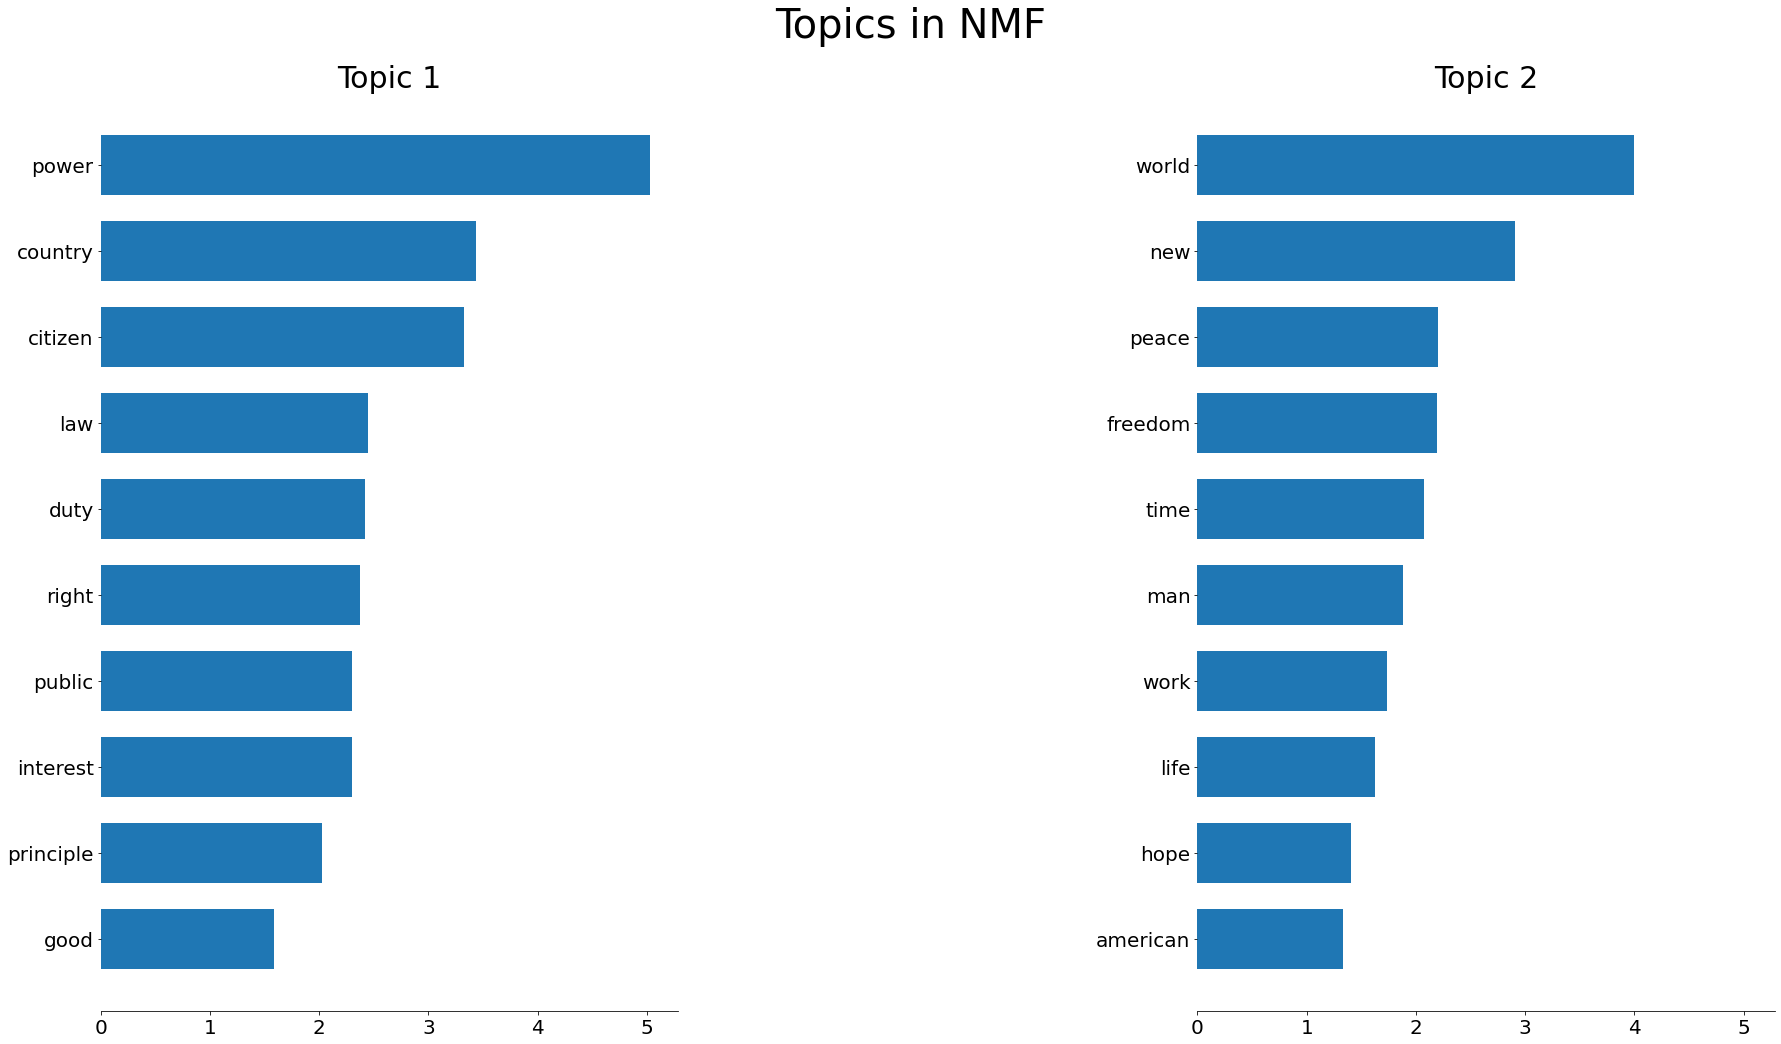

<Figure size 432x288 with 0 Axes>

In [115]:
n_top_words = 10
plot_top_words(nmf_model,words,n_top_words, 'Topics in NMF',1,2)

In [91]:
# View tsnse topic plot
path = path = r"C:\Users\Andrew\Documents\Metis\NLP_Inaugural_Addresses\Data\Visualization"

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(nmf_model, doc_word, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, path + '\\nmf_2topics.html')

## Lemmatized (LDA)

In [28]:
# Seperate text from dataframe
text = df['address']

In [29]:
# Remove stopwords
text = remove_stopwords(text)

In [30]:
# Lemmatize
text = lemma(text)

In [31]:
# Create count vectorizer
count_vectorizer = CountVectorizer(analyzer='word',token_pattern=r'\b[^\d\W]+\b',stop_words = stopwords,ngram_range = (1,2),min_df=0.1)
count_vectorizer.fit(text)

CountVectorizer(min_df=0.1, ngram_range=(1, 2),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                token_pattern='\\b[^\\d\\W]+\\b')

In [32]:
# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = count_vectorizer.transform(text).transpose()
doc_word

<1643x59 sparse matrix of type '<class 'numpy.int64'>'
	with 24137 stored elements in Compressed Sparse Column format>

In [33]:
# View Dataframe
pd.DataFrame(doc_word.toarray(), count_vectorizer.get_feature_names()).head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
abandon,0,0,1,1,0,0,0,0,2,0,...,0,0,0,0,0,2,1,0,0,0
abide,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
ability,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
able,0,0,0,0,1,0,0,2,1,0,...,0,0,1,0,0,0,0,0,0,0
abroad,0,0,1,1,0,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,0


In [34]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

In [35]:
# Map matrix into tokens
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [36]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.ldamodel.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

In [37]:
lda.print_topics()

[(0,
  '0.015*"world" + 0.011*"new" + 0.008*"time" + 0.008*"man" + 0.008*"peace" + 0.007*"freedom" + 0.007*"life" + 0.006*"work" + 0.006*"country" + 0.006*"today"'),
 (1,
  '0.011*"power" + 0.010*"country" + 0.008*"citizen" + 0.008*"public" + 0.007*"right" + 0.007*"duty" + 0.006*"interest" + 0.006*"principle" + 0.005*"good" + 0.005*"law"'),
 (2,
  '0.011*"law" + 0.007*"country" + 0.006*"citizen" + 0.006*"good" + 0.006*"time" + 0.005*"peace" + 0.005*"power" + 0.005*"public" + 0.005*"man" + 0.005*"world"')]

In [38]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[corpus]

In [39]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

In [40]:
# Check out the document vectors in the topic space for the first 5 documents
lda_docs[0:5]

[[(1, 0.99806917)],
 [(0, 0.02562078), (1, 0.963598), (2, 0.010781159)],
 [(1, 0.9988205)],
 [(0, 0.1635895), (1, 0.83570296)],
 [(1, 0.99680805)]]

#### Creat t-sne plot

In [41]:
# Seperate text from dataframe
text = df['address']

In [42]:
# Remove stopwords
text = remove_stopwords(text)

In [43]:
# Lemmatize
text = lemma(text)

In [44]:
# Tokenize

text = [word_tokenize(x) for x in text]

In [45]:
# Remove stopwords
text = [t for t in text if t not in stopwords]

In [46]:
# Values

text = np.array(text)

In [47]:
dictionary = corpora.Dictionary(text)
corpus = [dictionary.doc2bow(i) for i in text]
ldamodel = models.ldamodel.LdaModel(corpus, id2word=dictionary, 
                                    num_topics=3, passes=5, minimum_probability=0)

In [48]:
ldamodel.print_topics()

[(0,
  '0.010*"people" + 0.008*"power" + 0.007*"country" + 0.007*"great" + 0.007*"government" + 0.006*"nation" + 0.006*"citizen" + 0.006*"make" + 0.006*"law" + 0.005*"public"'),
 (1,
  '0.011*"nation" + 0.010*"people" + 0.010*"world" + 0.007*"new" + 0.006*"great" + 0.006*"make" + 0.006*"time" + 0.006*"government" + 0.006*"peace" + 0.006*"man"'),
 (2,
  '0.003*"nation" + 0.003*"people" + 0.002*"public" + 0.002*"citizen" + 0.002*"great" + 0.002*"government" + 0.001*"law" + 0.001*"country" + 0.001*"give" + 0.001*"time"')]

In [49]:
hm = np.array([[y for (x,y) in ldamodel[corpus[i]]] for i in range(len(corpus))])

In [50]:
tsne = TSNE(random_state=0, verbose=0)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)

In [51]:
df.columns

Index(['president_number', 'term', 'pres_name', 'pres_det', 'president_x',
       'address', 'party', 'Year', 'time_period', 'topic'],
      dtype='object')

In [52]:
source = ColumnDataSource(
        data=dict(
            x = embedding.x,
            y = embedding.y,
            colors = [all_palettes['Set1'][8][i] for i in embedding.hue],
            title = df.pres_name,
            year = df.Year,
            term = df.term,
            alpha = [0.9] * embedding.shape[0],
            size = [7] * embedding.shape[0]
        )
    )
hover_tsne = HoverTool(names=["df"], tooltips="""
    <div style="margin: 10">
        <div style="margin: 0 auto; width:300px;">
            <span style="font-size: 12px; font-weight: bold;">Title:</span>
            <span style="font-size: 12px">@title</span>
            <span style="font-size: 12px; font-weight: bold;">Year:</span>
            <span style="font-size: 12px">@year</span>
        </div>
    </div>
    """)
tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']
plot_tsne = figure(plot_width=700, plot_height=700, tools=tools_tsne, title='Addresses')
plot_tsne.circle('x', 'y', size='size', fill_color='colors', 
                 alpha='alpha', line_alpha=0, line_width=0.01, source=source, name="df")

callback = CustomJS(args=dict(source=source), code=
    """
    var data = source.data;
    var f = cb_obj.value
    x = data['x']
    y = data['y']
    colors = data['colors']
    alpha = data['alpha']
    title = data['title']
    year = data['year']
    size = data['size']
    for (i = 0; i < x.length; i++) {
        if (year[i] <= f) {
            alpha[i] = 0.9
            size[i] = 7
        } else {
            alpha[i] = 0.05
            size[i] = 4
        }
    }
    source.change.emit();
    """)

slider = Slider(start=df.Year.min(), end=df.Year.max(), value=2021, step=1, title="Before year")
slider.js_on_change('value', callback)

layout = column(slider, plot_tsne)
#show(layout)

## Sentiment Analysis

In [53]:
# Seperate text from dataframe
text = df['address']

In [54]:
# Remove stopwords
text = remove_stopwords(text)

In [55]:
# Lemmatize
text = lemma(text)

In [56]:
# Sentiment Score for Each Address
scores = [SentimentIntensityAnalyzer().polarity_scores(i)['pos'] for i in text]
scores = pd.Series(scores)

In [57]:
# Concat scores with president names
names = df['pres_det']
sent_score = pd.concat([names,scores], axis = 1)

In [58]:
# Send to csv for Tableau
path = r"C:\Users\Andrew\Documents\Metis\NLP_Inaugural_Addresses\Data\Visualization"
sent_score.to_csv(os.path.join(path,r'sentiment_analysis.csv'))